In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import gurobipy
%pip install pypsa[highs] "xarray>=2023.8.0" Cartopy highspy

Note: you may need to restart the kernel to use updated packages.


In [4]:
from gurobipy import *
from add_country import *

In [5]:
import pypsa
import pandas as pd
from dataclasses import dataclass

In [10]:
countries = {"Scandinavia", "Germany", "Poland", "France", "Iberian"}
#for country in countries:
full_demand = pd.read_csv(f"./data/demand_2030_Scandinavia.csv", sep=";", index_col=1, parse_dates=True).groupby(pd.Grouper(key="climatic_year"))
full_wind_on_shore= pd.read_csv("./data/capa_factor_2030_scandinavia_onshore.csv", index_col=1, parse_dates=True, sep=";").groupby(pd.Grouper(key="climatic_year"))
full_solar = pd.read_csv("./data/capa_factor_2030_scandinavia_solar.csv", index_col=1, parse_dates=True, sep=";").groupby(pd.Grouper(key="climatic_year"))
full_wind_off_shore = pd.read_csv("./data/capa_factor_2030_scandinavia_offshore.csv", index_col=1, parse_dates=True, sep=";").groupby(pd.Grouper(key="climatic_year"))
    



In [11]:
climatic_year = 2000
time_horizon_in_hours = 365 * 24

In [12]:
demand = full_demand.get_group(climatic_year)
solar = full_solar.get_group(climatic_year)
wind_on_shore = full_wind_on_shore.get_group(climatic_year)
wind_off_shore = full_wind_off_shore.get_group(climatic_year)

In [13]:
network = pypsa.Network(snapshots=demand.index[0:time_horizon_in_hours])

In [14]:
network.add("Bus", name="Scandinavia", x=15.255119, y=60.128161)
network.add("Bus", name="Curtailment", x=10, y=65)
network.add("Bus", name="Poland", x=21.0117800, y=52.2297700)
network.add("Bus", name="Germany", x=13.4105300, y=52.5243700)
#network.add("Bus", name="Benelux", x=4.3487800, y=50.8504500)
network.add("Bus", name="France", x=2.3488000, y=48.8534100)
network.add("Bus", name="Iberian", x=-3.7025600, y=40.4165000)

In [ ]:
@dataclass
class Carriers:
    Battery = 0
    Biomass = 230
    Coal = 760
    Gas = 370
    Oil = 406
    Hydrogen = 490
    Hydro = 24
    Nuclear = 12
    Pumped = 0
    Reservoir = 0
    Solar = 45
    Wind = 11

In [ ]:
for name, co2_emission in Carriers().__dict__.items():
    network.add("Carrier", name=name, co2_emissions=co2_emission)

In [ ]:
#???
coal_marginal_costs = 160
gas_marginal_costs = 120
oil_marginal_costs = 100
nuclear_marginal_costs = 10
hydro_marginal_costs = 5
wind_marginal_costs = 5
solar_marginal_costs = 5
biomass_marginal_costs = 5


reservoir_max_hours = 365*24
pumped_max_hours = 100
battery_max_hours = 200
H2_max_hours = 300



#coal_marginal_costs = 128 / 7 / 0.37 
#gas_marginal_costs = 2.65 * 26.4 * 0.75 / 14.9 / 0.5
#oil_marginal_costs = 73 * 0.119 / 12.5 / 0.40

In [ ]:
generators = [
    #{"name": "Coal", "carrier": "Coal", "p_nom": 2112, "p_min_pu": 0, "p_max_pu": 1, "marginal_cost": coal_marginal_costs, "efficiency": 0.37, "committable": True, "min_up_time": 1, "min_down_time": 1},
    #{"name": "Gas", "carrier": "Gas", "p_nom": 2640, "p_min_pu": 0, "p_max_pu": 1, "marginal_cost": gas_marginal_costs, "efficiency": 0.5,
    # "committable": True, "min_up_time": 1, "min_down_time": 1},
    #{"name": "Oil", "carrier": "Oil", "p_nom": 0, "p_min_pu": 0, "p_max_pu": 1, "marginal_cost": oil_marginal_costs, "efficiency": 0.4,
    # "committable": True, "min_up_time": 1, "min_down_time": 1},
    {"name": "Fossils", "carrier": "Fossils", "p_nom": 5000, "p_min_pu": 0, "p_max_pu": 1, "marginal_cost": gas_marginal_costs, "efficiency": 0.4,
     "committable": True, "min_up_time": 1, "min_down_time": 1},
    {"name": "BioEnergies", "carrier": "BioEnergies", "p_nom":11000, "p_min_pu": 0, "p_max_pu": 1, "marginal_cost": biomass_marginal_costs, "efficiency": 0.5, 
     "committable": True, "min_up_time": 1, "min_down_time": 1},
    {"name": "Hydroelectric", "carrier":"Hydro", "p_nom": 57000, "p_min_pu": 0, "p_max_pu": 1, "marginal_cost": hydro_marginal_costs, "efficiency": 1, "committable": True,
     "min_up_time": 1, "min_down_time": 1},
    {"name": "Wind_on_shore", "carrier": "Wind_on_shore", "p_nom": 43000, "p_min_pu":wind_on_shore.value, "p_max_pu": wind_on_shore.value, "marginal_cost": wind_marginal_costs, "efficiency":1, "committable": False,
     "min_up_time": 1, "min_down_time": 1},
    {"name": "Wind_off_shore", "carrier": "Wind_off_shore", "p_nom": 17000, "p_min_pu":wind_off_shore.value, "p_max_pu": wind_off_shore.value, "marginal_cost": wind_marginal_costs, "efficiency":1, "committable": False,
     "min_up_time": 1, "min_down_time": 1},
    {"name": "Nuclear", "carrier": "Nuclear", "p_nom": 11000, "p_min_pu":0, "p_max_pu": 1, "marginal_cost": nuclear_marginal_costs, "efficiency":1, "committable": True,
     "min_up_time": 24, "min_down_time": 24},
    {"name": "Solar", "carrier": "Solar", "p_nom": 19000, "p_min_pu":solar.value, "p_max_pu": solar.value, "marginal_cost": solar_marginal_costs, "efficiency":1, "committable": False,
     "min_up_time": 1, "min_down_time": 1},
    {"name": "Failure", "carrier": "Failure", "p_nom": 100000, "p_min_pu":0, "p_max_pu": 1, "marginal_cost": 100000, "efficiency":1, "committable": True,
     "min_up_time": 1, "min_down_time": 1},
    #{"name": "Curtailment", "carrier": "Curtailment", "p_nom": 100000, "p_min_pu":1, "p_max_pu": 1, "marginal_cost": 0, "efficiency":1, "committable": True,
     #"min_up_time": 1, "min_down_time": 1},
]

fictive_generator = [
    {"name": "Curtailment", "carrier": "Curtailment", "p_nom": 100000, "p_min_pu":0, "p_max_pu": 1, "marginal_cost": 0.0001, "efficiency":1, "committable": True,
     "min_up_time": 1, "min_down_time": 1}
]


storage_units = [
        {"name": "Reservoir", "carrier": "Reservoir", "p_nom": 100000, "p_min_pu": 0, "p_max_pu": 1, "max_hours": reservoir_max_hours, "efficiency": 1, "cyclic_state_of_charge": True, "p_nom_discharge" : 100, "p_nom_charge" : 100},
        {"name": "Pumped", "carrier": "Pumped", "p_nom": 100000, "p_min_pu": 0, "p_max_pu": 1, "max_hours": pumped_max_hours, "efficiency": 1, "cyclic_state_of_charge": True, "p_nom_discharge" : 100, "p_nom_charge" : 100},
        {"name": "Battery", "carrier": "Battery", "p_nom": 100000, "p_min_pu": 0, "p_max_pu": 1, "max_hours": battery_max_hours, "efficiency": 1, "cyclic_state_of_charge": True, "p_nom_discharge" : 100, "p_nom_charge" : 100},
        {"name": "H2", "carrier": "H2", "p_nom": 100000, "p_min_pu": 0, "p_max_pu": 1, "max_hours": H2_max_hours, "efficiency": 1, "cyclic_state_of_charge": True, "p_nom_discharge" :100, "p_nom_charge" : 100},
]



In [ ]:
for generator in generators:
    network.add("Generator", bus="Scandinavia", **generator,)
    
for generator in fictive_generator:
    network.add("Generator", bus="Curtailment", **generator,)
for storage in storage_units:
    network.add("Store", bus="Scandinavia", **storage,)

In [ ]:
#'carrier', "AC" ?? 

loads = [
    {"name": "Scandinavia-load", "bus": "Scandinavia", "carrier": "AC","p_set": demand[0:time_horizon_in_hours]["value"].values*1},
    {"name": "Curtailment-load", "bus": "Curtailment", "carrier": "AC","p_set": 10000},
]   

In [ ]:
for load in loads:
    network.add("Load", **load)

In [17]:
links_list = [
    {"name" : "Link_SCA_Curtailment", "bus0" : "Scandinavia", "bus1" : "Curtailment", "p_nom" : 700000, "efficiency" : 0.95},
    {"name" : "Link_SCA_Germany", "bus0":"Scandinavia", "bus1":"Germany", "p_nom":7415, "efficiency":0.95},
    {"name" : "Link_SCA_Poland", "bus0":"Scandinavia", "bus1":"Poland", "p_nom":600, "efficiency":0.95},
    #{"name" : "Link_SCA_Benelux", "bus0":"Scandinavia", "bus1":"Benelux", "p_nom":1400, "efficiency":0.95},
    #{"name" : "Link_Benelux_SCA", "bus0":"Benelux", "bus1":"Scandinavia", "p_nom":1400, "efficiency":0.95},
    {"name" : "Link_Poland_SCA", "bus0":"Poland", "bus1":"Scandinavia", "p_nom":0, "efficiency":0.95},
    {"name" : "Link_Germany_SCA", "bus0":"Germany", "bus1":"Scandinavia", "p_nom":2000, "efficiency":0.95},
    {"name" : "Link_France_Germany", "bus0":"France", "bus1":"Germany", "p_nom":3300, "efficiency":0.95},
    {"name" : "Link_Germany_France", "bus0":"Germany", "bus1":"France", "p_nom":3300, "efficiency":0.95},
    {"name" : "Link_Germany_Poland", "bus0":"Germany", "bus1":"Poland", "p_nom":3400, "efficiency":0.95},
    {"name" : "Link_Poland_Germany", "bus0":"Poland", "bus1":"Germany", "p_nom":3400, "efficiency":0.95},
    #{"name" : "Link_Germany_Benelux", "bus0":"Germany", "bus1":"Benelux", "p_nom":9300, "efficiency":0.95},
    #{"name" : "Link_Benelux_Germany", "bus0":"Benelux", "bus1":"Germany", "p_nom":9300, "efficiency":0.95},
    #{"name" : "Link_Benelux_France", "bus0":"Benelux", "bus1":"France", "p_nom":4680, "efficiency":0.95},
    #{"name" : "Link_France_Benelux", "bus0":"France", "bus1":"Benelux", "p_nom":4680, "efficiency":0.95},
    {"name" : "Link_France_Iberian", "bus0":"France", "bus1":"Iberian", "p_nom":5000, "efficiency":0.95},
    {"name" : "Link_Iberian_France", "bus0":"Iberian", "bus1":"France", "p_nom":5000, "efficiency":0.95},
]

for links in links_list:
    network.add("Link", **links,)

#network.add("Link",
#            "Link_SCA_Curtailment",  # Unique identifier for the link
#            bus0="Scandinavia",    # Name of the first country/bus
##            bus1="Curtailment",    # Name of the second country/bus
 #           p_nom=700000,           # Transmission capacity in MW (adjust as needed)
 #           efficiency=0.95,      # Transmission efficiency (adjust as needed)
 #          )

In [18]:
network

PyPSA Network
Components:
 - Bus: 6
 - Link: 11
Snapshots: 8760

(<matplotlib.collections.PatchCollection at 0x7fc1722f1b70>,
 <matplotlib.collections.LineCollection at 0x7fc1722f27a0>)

/Users/alexandrerebiere/Documents/anaconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning:

facecolor will have no effect as it has been defined as "never".



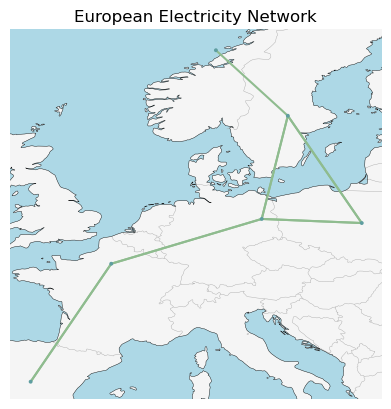

In [19]:
network.plot(
    title="European Electricity Network",
    color_geomap=True,
    jitter=0.3,
)

In [21]:
result = network.optimize(solver_name="gurobi")
print(result)   

INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy.gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2024-11-21


INFO:gurobipy.gurobipy:Academic license - for non-commercial use only - expires 2024-11-21
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|█████████████████████████████████████████| 3/3 [00:00<00:00, 19.39it/s]
INFO:linopy.io: Writing time: 4.63s


Read LP format model from file /private/var/folders/ms/4_rjwj4n1h1gg3k7zdvmsv5m0000gn/T/linopy-problem-1aqhx6hs.lp


INFO:gurobipy.gurobipy:Read LP format model from file /private/var/folders/ms/4_rjwj4n1h1gg3k7zdvmsv5m0000gn/T/linopy-problem-1aqhx6hs.lp


Reading time = 1.28 seconds


INFO:gurobipy.gurobipy:Reading time = 1.28 seconds


obj: 534371 rows, 297840 columns, 1462355 nonzeros


INFO:gurobipy.gurobipy:obj: 534371 rows, 297840 columns, 1462355 nonzeros


Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[x86])


INFO:gurobipy.gurobipy:Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[x86])


INFO:gurobipy.gurobipy:


CPU model: Intel(R) Core(TM) i5-8259U CPU @ 2.30GHz


INFO:gurobipy.gurobipy:CPU model: Intel(R) Core(TM) i5-8259U CPU @ 2.30GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy.gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy.gurobipy:


Optimize a model with 534371 rows, 297840 columns and 1462355 nonzeros


INFO:gurobipy.gurobipy:Optimize a model with 534371 rows, 297840 columns and 1462355 nonzeros


Model fingerprint: 0x5fdb6deb


INFO:gurobipy.gurobipy:Model fingerprint: 0x5fdb6deb


Variable types: 140160 continuous, 157680 integer (157680 binary)


INFO:gurobipy.gurobipy:Variable types: 140160 continuous, 157680 integer (157680 binary)


Coefficient statistics:


INFO:gurobipy.gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 1e+05]


INFO:gurobipy.gurobipy:  Matrix range     [9e-01, 1e+05]


  Objective range  [1e-04, 1e+05]


INFO:gurobipy.gurobipy:  Objective range  [1e-04, 1e+05]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy.gurobipy:  Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 7e+05]


INFO:gurobipy.gurobipy:  RHS range        [1e+00, 7e+05]


Presolve removed 498215 rows and 297835 columns (presolve time = 6s) ...


INFO:gurobipy.gurobipy:Presolve removed 498215 rows and 297835 columns (presolve time = 6s) ...


Presolve removed 534369 rows and 297835 columns


INFO:gurobipy.gurobipy:Presolve removed 534369 rows and 297835 columns


Presolve time: 5.91s


INFO:gurobipy.gurobipy:Presolve time: 5.91s


Presolved: 2 rows, 5 columns, 6 nonzeros


INFO:gurobipy.gurobipy:Presolved: 2 rows, 5 columns, 6 nonzeros


Variable types: 4 continuous, 1 integer (1 binary)


INFO:gurobipy.gurobipy:Variable types: 4 continuous, 1 integer (1 binary)


INFO:gurobipy.gurobipy:


Root simplex log...


INFO:gurobipy.gurobipy:Root simplex log...


INFO:gurobipy.gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy.gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.3077589e+09   2.612500e+03   0.000000e+00      6s


INFO:gurobipy.gurobipy:       0    3.3077589e+09   2.612500e+03   0.000000e+00      6s


       1    3.3078139e+09   0.000000e+00   0.000000e+00      6s


INFO:gurobipy.gurobipy:       1    3.3078139e+09   0.000000e+00   0.000000e+00      6s


INFO:gurobipy.gurobipy:


Root relaxation: objective 3.307814e+09, 1 iterations, 0.02 seconds (0.00 work units)


INFO:gurobipy.gurobipy:Root relaxation: objective 3.307814e+09, 1 iterations, 0.02 seconds (0.00 work units)


INFO:gurobipy.gurobipy:


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy.gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy.gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy.gurobipy:


*    0     0               0    3.307814e+09 3.3078e+09  0.00%     -    6s


INFO:gurobipy.gurobipy:*    0     0               0    3.307814e+09 3.3078e+09  0.00%     -    6s


INFO:gurobipy.gurobipy:


Explored 1 nodes (1 simplex iterations) in 6.33 seconds (7.65 work units)


INFO:gurobipy.gurobipy:Explored 1 nodes (1 simplex iterations) in 6.33 seconds (7.65 work units)


Thread count was 8 (of 8 available processors)


INFO:gurobipy.gurobipy:Thread count was 8 (of 8 available processors)


INFO:gurobipy.gurobipy:


Solution count 1: 3.30781e+09 


INFO:gurobipy.gurobipy:Solution count 1: 3.30781e+09 


No other solutions better than 3.30781e+09


INFO:gurobipy.gurobipy:No other solutions better than 3.30781e+09


INFO:gurobipy.gurobipy:


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy.gurobipy:Optimal solution found (tolerance 1.00e-04)


Best objective 3.307813861849e+09, best bound 3.307813861849e+09, gap 0.0000%


INFO:gurobipy.gurobipy:Best objective 3.307813861849e+09, best bound 3.307813861849e+09, gap 0.0000%
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 297840 primals, 0 duals
Objective: 3.31e+09
Solver model: available
Solver message: 2



('ok', 'optimal')


<Axes: xlabel='Generator', ylabel='GW'>

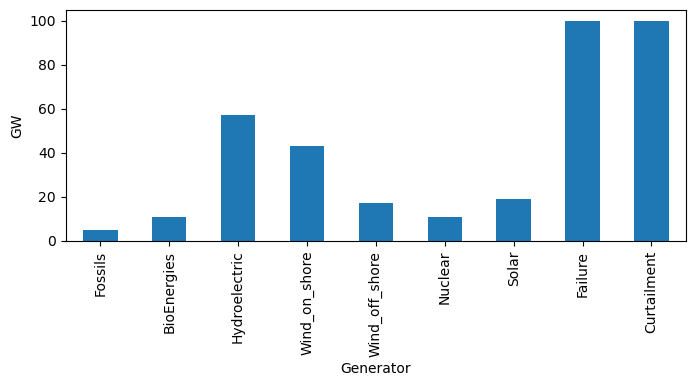

In [21]:
network.generators.p_nom_opt.div(1e3).plot.bar(ylabel="GW", figsize=(8, 3))

ValueError: When stacked is True, each column must be either all positive or all negative. Column 'Failure' contains both positive and negative values

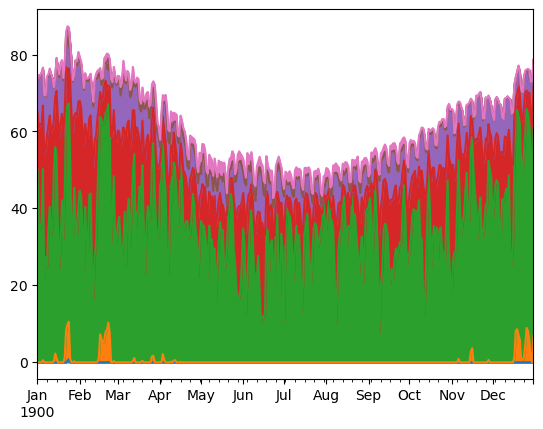

In [22]:
network.generators_t.p.resample('D').mean().div(1e3).plot.area(subplots=False, ylabel="GW")

ValueError: When stacked is True, each column must be either all positive or all negative. Column 'Failure' contains both positive and negative values

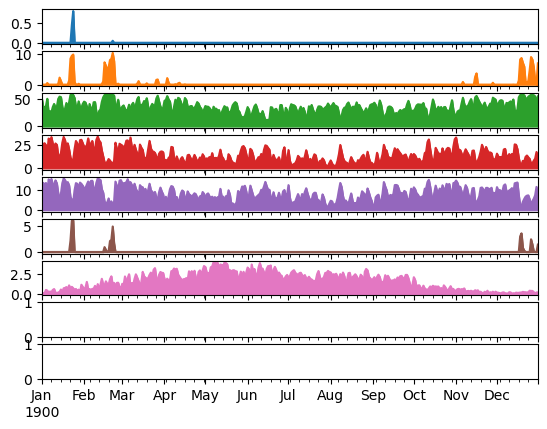

In [31]:
network.generators_t.p.resample('D').mean().div(1e3).plot.area(subplots=True, ylabel="GW")

array([<Axes: xlabel='snapshot', ylabel='GW'>,
       <Axes: xlabel='snapshot', ylabel='GW'>,
       <Axes: xlabel='snapshot', ylabel='GW'>,
       <Axes: xlabel='snapshot', ylabel='GW'>,
       <Axes: xlabel='snapshot', ylabel='GW'>,
       <Axes: xlabel='snapshot', ylabel='GW'>,
       <Axes: xlabel='snapshot', ylabel='GW'>,
       <Axes: xlabel='snapshot', ylabel='GW'>,
       <Axes: xlabel='snapshot', ylabel='GW'>], dtype=object)

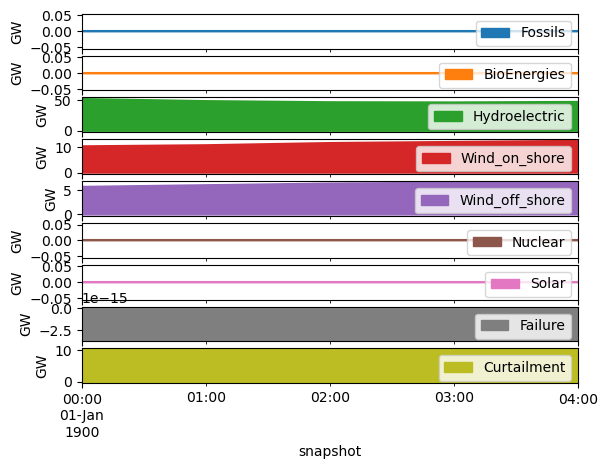

In [30]:
network.generators_t.p.head().div(1e3).plot.area(subplots=True, ylabel="GW")

In [24]:
network.generators_t.p.min()

Generator
Fossils           0.000000e+00
BioEnergies       0.000000e+00
Hydroelectric     1.303190e+03
Wind_on_shore     8.600000e+02
Wind_off_shore    6.800000e+02
Nuclear           0.000000e+00
Solar             0.000000e+00
Failure          -3.637979e-12
Curtailment       1.000000e+04
dtype: float64

In [25]:
network.generators_t.p.idxmin()

Generator
Fossils          1900-01-01 00:00:00
BioEnergies      1900-01-01 00:00:00
Hydroelectric    1900-06-03 12:00:00
Wind_on_shore    1900-09-02 00:00:00
Wind_off_shore   1900-09-01 21:00:00
Nuclear          1900-01-01 00:00:00
Solar            1900-01-01 00:00:00
Failure          1900-01-01 00:00:00
Curtailment      1900-01-01 00:00:00
dtype: datetime64[ns]

In [26]:
network.generators_t.p['Failure'].head(30)

snapshot
1900-01-01 00:00:00   -3.637979e-12
1900-01-01 01:00:00   -3.637979e-12
1900-01-01 02:00:00   -3.637979e-12
1900-01-01 03:00:00   -3.637979e-12
1900-01-01 04:00:00   -3.637979e-12
1900-01-01 05:00:00   -3.637979e-12
1900-01-01 06:00:00   -3.637979e-12
1900-01-01 07:00:00   -3.637979e-12
1900-01-01 08:00:00   -3.637979e-12
1900-01-01 09:00:00   -3.637979e-12
1900-01-01 10:00:00   -3.637979e-12
1900-01-01 11:00:00   -3.637979e-12
1900-01-01 12:00:00   -3.637979e-12
1900-01-01 13:00:00   -3.637979e-12
1900-01-01 14:00:00   -3.637979e-12
1900-01-01 15:00:00   -3.637979e-12
1900-01-01 16:00:00   -3.637979e-12
1900-01-01 17:00:00   -3.637979e-12
1900-01-01 18:00:00   -3.637979e-12
1900-01-01 19:00:00   -3.637979e-12
1900-01-01 20:00:00   -3.637979e-12
1900-01-01 21:00:00   -3.637979e-12
1900-01-01 22:00:00    0.000000e+00
1900-01-01 23:00:00    0.000000e+00
1900-01-02 00:00:00    0.000000e+00
1900-01-02 01:00:00    0.000000e+00
1900-01-02 02:00:00    0.000000e+00
1900-01-02 03:00:00

In [ ]:
%load_ext autoreload
%autoreload 2

import gurobipy
%pip install pypsa[highs] "xarray>=2023.8.0" Cartopy highspy

from gurobipy import *

import pypsa
import pandas as pd
from dataclasses import dataclass

full_demand = pd.read_csv("./data/demand_2030_scandinavia.csv", sep=";", index_col=1, parse_dates=True).groupby(pd.Grouper(key="climatic_year"))
full_wind_on_shore = pd.read_csv("./data/capa_factor_2030_scandinavia_onshore.csv", index_col=1, parse_dates=True, sep=";").groupby(pd.Grouper(key="climatic_year"))
full_solar = pd.read_csv("./data/capa_factor_2030_scandinavia_solar.csv", index_col=1, parse_dates=True, sep=";").groupby(pd.Grouper(key="climatic_year"))
full_wind_off_shore = pd.read_csv("./data/capa_factor_2030_scandinavia_offshore.csv", index_col=1, parse_dates=True, sep=";").groupby(pd.Grouper(key="climatic_year"))




climatic_year = 2000
time_horizon_in_hours = 365 * 24

demand = full_demand.get_group(climatic_year)
solar = full_solar.get_group(climatic_year)
wind_on_shore = full_wind_on_shore.get_group(climatic_year)
wind_off_shore = full_wind_off_shore.get_group(climatic_year)

network = pypsa.Network(snapshots=demand.index[0:time_horizon_in_hours])

network.add("Bus", name="Scandinavia", x=15.255119, y=60.128161)
network.add("Bus", name="Curtailment", x=10, y=65)
network.add("Bus", name="Poland", x=21.0117800, y=52.2297700)
network.add("Bus", name="Germany", x=13.4105300, y=52.5243700)
network.add("Bus", name="Benelux", x=4.3487800, y=50.8504500)
network.add("Bus", name="France", x=2.3488000, y=48.8534100)
network.add("Bus", name="Iberian", x=-3.7025600, y=40.4165000)

@dataclass
class Carriers:
    Battery = 0
    Biomass = 230
    Coal = 760
    Gas = 370
    Oil = 406
    Hydrogen = 490
    Hydro = 24
    Nuclear = 12
    Pumped = 0
    Reservoir = 0
    Solar = 45
    Wind = 11

for name, co2_emission in Carriers().__dict__.items():
    network.add("Carrier", name=name, co2_emissions=co2_emission)

#???
coal_marginal_costs = 160
gas_marginal_costs = 120
oil_marginal_costs = 100
nuclear_marginal_costs = 10
hydro_marginal_costs = 5
wind_marginal_costs = 5
solar_marginal_costs = 5
biomass_marginal_costs = 5


reservoir_max_hours = 365*24
pumped_max_hours = 100
battery_max_hours = 200
H2_max_hours = 300



#coal_marginal_costs = 128 / 7 / 0.37 
#gas_marginal_costs = 2.65 * 26.4 * 0.75 / 14.9 / 0.5
#oil_marginal_costs = 73 * 0.119 / 12.5 / 0.40

generators = [
    #{"name": "Coal", "carrier": "Coal", "p_nom": 2112, "p_min_pu": 0, "p_max_pu": 1, "marginal_cost": coal_marginal_costs, "efficiency": 0.37, "committable": True, "min_up_time": 1, "min_down_time": 1},
    #{"name": "Gas", "carrier": "Gas", "p_nom": 2640, "p_min_pu": 0, "p_max_pu": 1, "marginal_cost": gas_marginal_costs, "efficiency": 0.5,
    # "committable": True, "min_up_time": 1, "min_down_time": 1},
    #{"name": "Oil", "carrier": "Oil", "p_nom": 0, "p_min_pu": 0, "p_max_pu": 1, "marginal_cost": oil_marginal_costs, "efficiency": 0.4,
    # "committable": True, "min_up_time": 1, "min_down_time": 1},
    {"name": "Fossils", "carrier": "Fossils", "p_nom": 5000, "p_min_pu": 0, "p_max_pu": 1, "marginal_cost": gas_marginal_costs, "efficiency": 0.4,
     "committable": True, "min_up_time": 1, "min_down_time": 1},
    {"name": "BioEnergies", "carrier": "BioEnergies", "p_nom":11000, "p_min_pu": 0, "p_max_pu": 1, "marginal_cost": biomass_marginal_costs, "efficiency": 0.5, 
     "committable": True, "min_up_time": 1, "min_down_time": 1},
    {"name": "Hydroelectric", "carrier":"Hydro", "p_nom": 57000, "p_min_pu": 0, "p_max_pu": 1, "marginal_cost": hydro_marginal_costs, "efficiency": 1, "committable": True,
     "min_up_time": 1, "min_down_time": 1},
    {"name": "Wind_on_shore", "carrier": "Wind_on_shore", "p_nom": 43000, "p_min_pu":wind_on_shore.value, "p_max_pu": wind_on_shore.value, "marginal_cost": wind_marginal_costs, "efficiency":1, "committable": False,
     "min_up_time": 1, "min_down_time": 1},
    {"name": "Wind_off_shore", "carrier": "Wind_off_shore", "p_nom": 17000, "p_min_pu":wind_off_shore.value, "p_max_pu": wind_off_shore.value, "marginal_cost": wind_marginal_costs, "efficiency":1, "committable": False,
     "min_up_time": 1, "min_down_time": 1},
    {"name": "Nuclear", "carrier": "Nuclear", "p_nom": 11000, "p_min_pu":0, "p_max_pu": 1, "marginal_cost": nuclear_marginal_costs, "efficiency":1, "committable": True,
     "min_up_time": 24, "min_down_time": 24},
    {"name": "Solar", "carrier": "Solar", "p_nom": 19000, "p_min_pu":solar.value, "p_max_pu": solar.value, "marginal_cost": solar_marginal_costs, "efficiency":1, "committable": False,
     "min_up_time": 1, "min_down_time": 1},
    {"name": "Failure", "carrier": "Failure", "p_nom": 100000, "p_min_pu":0, "p_max_pu": 1, "marginal_cost": 100000, "efficiency":1, "committable": True,
     "min_up_time": 1, "min_down_time": 1},
    #{"name": "Curtailment", "carrier": "Curtailment", "p_nom": 100000, "p_min_pu":1, "p_max_pu": 1, "marginal_cost": 0, "efficiency":1, "committable": True,
     #"min_up_time": 1, "min_down_time": 1},
]

fictive_generator = [
    {"name": "Curtailment", "carrier": "Curtailment", "p_nom": 100000, "p_min_pu":0, "p_max_pu": 1, "marginal_cost": 0.0001, "efficiency":1, "committable": True,
     "min_up_time": 1, "min_down_time": 1}
]


storage_units = [
        {"name": "Reservoir", "carrier": "Reservoir", "p_nom": 100000, "p_min_pu": 0, "p_max_pu": 1, "max_hours": reservoir_max_hours, "efficiency": 1, "cyclic_state_of_charge": True, "p_nom_discharge" : 100, "p_nom_charge" : 100},
        {"name": "Pumped", "carrier": "Pumped", "p_nom": 100000, "p_min_pu": 0, "p_max_pu": 1, "max_hours": pumped_max_hours, "efficiency": 1, "cyclic_state_of_charge": True, "p_nom_discharge" : 100, "p_nom_charge" : 100},
        {"name": "Battery", "carrier": "Battery", "p_nom": 100000, "p_min_pu": 0, "p_max_pu": 1, "max_hours": battery_max_hours, "efficiency": 1, "cyclic_state_of_charge": True, "p_nom_discharge" : 100, "p_nom_charge" : 100},
        {"name": "H2", "carrier": "H2", "p_nom": 100000, "p_min_pu": 0, "p_max_pu": 1, "max_hours": H2_max_hours, "efficiency": 1, "cyclic_state_of_charge": True, "p_nom_discharge" :100, "p_nom_charge" : 100},
]





for generator in generators:
    network.add("Generator", bus="Scandinavia", **generator,)
    
for generator in fictive_generator:
    network.add("Generator", bus="Curtailment", **generator,)
#for storage in storage_units:
#    network.add("Store", bus="Scandinavia", **storage,)

#'carrier', "AC" ?? 

loads = [
    {"name": "Scandinavia-load", "bus": "Scandinavia", "carrier": "AC","p_set": demand[0:time_horizon_in_hours]["value"].values*1},
    {"name": "Curtailment-load", "bus": "Curtailment", "carrier": "AC","p_set": 10000},
]   

for load in loads:
    network.add("Load", **load)

links_list = [
    {"name" : "Link_SCA_Curtailment", "bus0" : "Scandinavia", "bus1" : "Curtailment", "p_nom" : 700000, "efficiency" : 0.95},
    {"name" : "Link_SCA_Germany", "bus0":"Scandinavia", "bus1":"Germany", "p_nom":7415, "efficiency":0.95},
    {"name" : "Link_SCA_Poland", "bus0":"Scandinavia", "bus1":"Poland", "p_nom":600, "efficiency":0.95},
    {"name" : "Link_SCA_Benelux", "bus0":"Scandinavia", "bus1":"Benelux", "p_nom":1400, "efficiency":0.95},
    {"name" : "Link_Benelux_SCA", "bus0":"Benelux", "bus1":"Scandinavia", "p_nom":1400, "efficiency":0.95},
    {"name" : "Link_Poland_SCA", "bus0":"Poland", "bus1":"Scandinavia", "p_nom":0, "efficiency":0.95},
    {"name" : "Link_Germany_SCA", "bus0":"Germany", "bus1":"Scandinavia", "p_nom":2000, "efficiency":0.95},
    {"name" : "Link_France_Germany", "bus0":"France", "bus1":"Germany", "p_nom":3300, "efficiency":0.95},
    {"name" : "Link_Germany_France", "bus0":"Germany", "bus1":"France", "p_nom":3300, "efficiency":0.95},
    {"name" : "Link_Germany_Poland", "bus0":"Germany", "bus1":"Poland", "p_nom":3400, "efficiency":0.95},
    {"name" : "Link_Poland_Germany", "bus0":"Poland", "bus1":"Germany", "p_nom":3400, "efficiency":0.95},
    {"name" : "Link_Germany_Benelux", "bus0":"Germany", "bus1":"Benelux", "p_nom":9300, "efficiency":0.95},
    {"name" : "Link_Benelux_Germany", "bus0":"Benelux", "bus1":"Germany", "p_nom":9300, "efficiency":0.95},
    {"name" : "Link_Benelux_France", "bus0":"Benelux", "bus1":"France", "p_nom":4680, "efficiency":0.95},
    {"name" : "Link_France_Benelux", "bus0":"France", "bus1":"Benelux", "p_nom":4680, "efficiency":0.95},
    {"name" : "Link_France_Iberian", "bus0":"France", "bus1":"Iberian", "p_nom":5000, "efficiency":0.95},
    {"name" : "Link_Iberian_France", "bus0":"Iberian", "bus1":"France", "p_nom":5000, "efficiency":0.95},
]

for links in links_list:
    network.add("Link", **links,)

#network.add("Link",
#            "Link_SCA_Curtailment",  # Unique identifier for the link
#            bus0="Scandinavia",    # Name of the first country/bus
##            bus1="Curtailment",    # Name of the second country/bus
 #           p_nom=700000,           # Transmission capacity in MW (adjust as needed)
 #           efficiency=0.95,      # Transmission efficiency (adjust as needed)
 #          )

network

network.plot(
    title="European Electricity Network",
    color_geomap=True,
    jitter=0.3,
)

result = network.optimize(solver_name="gurobi")
print(result)   

network.generators.p_nom_opt.div(1e3).plot.bar(ylabel="GW", figsize=(8, 3))

network.generators_t.p.resample('D').mean().div(1e3).plot.area(subplots=False, ylabel="GW")

network.generators_t.p.resample('D').mean().div(1e3).plot.area(subplots=True, ylabel="GW")

network.generators_t.p.head().div(1e3).plot.area(subplots=True, ylabel="GW")

network.generators_t.p.min()

network.generators_t.p.idxmin()

network.generators_t.p['Failure'].head(30)













